[![Fixel Algorithms](https://i.imgur.com/AqKHVZ0.png)](https://fixelalgorithms.gitlab.io/)

# Calibrating Imbalanced

## Machine Learning - Supervised Learning - Classification Performance Scores / Metrics: Precision, Recall, ROC and AUC - Exercise

> Notebook by:
> - Royi Avital RoyiAvital@fixelalgorithms.com

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 1.0.000 | 15/03/2024 | Royi Avital | First version                                                      |

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/AIProgram/2024_02/0036PerformanceScoreMetrics.ipynb)

In [1]:
# Import Packages

# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Machine Learning
from sklearn.datasets import make_moons
from sklearn.metrics import auc, roc_curve
from sklearn.svm import SVC

# Image Processing

# Machine Learning

# Miscellaneous
import math
import os
from platform import python_version
import random
import timeit

# Typing
from typing import Callable, Dict, List, Optional, Set, Tuple, Union

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Jupyter
from IPython import get_ipython
from IPython.display import Image
from IPython.display import display
from ipywidgets import Dropdown, FloatSlider, interact, IntSlider, Layout, SelectionSlider
from ipywidgets import interact

## Notations

* <font color='red'>(**?**)</font> Question to answer interactively.
* <font color='blue'>(**!**)</font> Simple task to add code for the notebook.
* <font color='green'>(**@**)</font> Optional / Extra self practice.
* <font color='brown'>(**#**)</font> Note / Useful resource / Food for thought.

Code Notations:

```python
someVar    = 2; #<! Notation for a variable
vVector    = np.random.rand(4) #<! Notation for 1D array
mMatrix    = np.random.rand(4, 3) #<! Notation for 2D array
tTensor    = np.random.rand(4, 3, 2, 3) #<! Notation for nD array (Tensor)
tuTuple    = (1, 2, 3) #<! Notation for a tuple
lList      = [1, 2, 3] #<! Notation for a list
dDict      = {1: 3, 2: 2, 3: 1} #<! Notation for a dictionary
oObj       = MyClass() #<! Notation for an object
dfData     = pd.DataFrame() #<! Notation for a data frame
dsData     = pd.Series() #<! Notation for a series
hObj       = plt.Axes() #<! Notation for an object / handler / function handler
```

### Code Exercise

 - Single line fill

 ```python
 vallToFill = ???
 ```

 - Multi Line to Fill (At least one)

 ```python
 # You need to start writing
 ????
 ```

 - Section to Fill

```python
#===========================Fill This===========================#
# 1. Explanation about what to do.
# !! Remarks to follow / take under consideration.
mX = ???

???
#===============================================================#
```

In [ ]:
# Configuration
# %matplotlib inline

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

# Matplotlib default color palette
lMatPltLibclr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
# sns.set_theme() #>! Apply SeaBorn theme

runInGoogleColab = 'google.colab' in str(get_ipython())

In [ ]:
# Constants

FIG_SIZE_DEF    = (8, 8)
ELM_SIZE_DEF    = 50
CLASS_COLOR     = ('b', 'r')
EDGE_COLOR      = 'k'
MARKER_SIZE_DEF = 10
LINE_WIDTH_DEF  = 2

In [4]:
# Courses Packages
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from utils.DataVisualization import PlotBinaryClassData, PlotConfusionMatrix, PlotLabelsHistogram

In [5]:
# General Auxiliary Functions

def PlotDecisionBoundaryClosure( numGridPts: int, gridXMin: float, gridXMax: float, gridYMin: float, gridYMax: float, numDigits: int = 1 ) -> Callable:

    # v0       = np.linspace(gridXMin, gridXMax, numGridPts)
    # v1       = np.linspace(gridYMin, gridYMax, numGridPts)
    roundFctr = 10 ** numDigits
    
    # For equal axis
    minVal = np.floor(roundFctr * min(gridXMin, gridYMin)) / roundFctr
    maxVal = np.ceil(roundFctr * max(gridXMax, gridYMax)) / roundFctr
    v0     = np.linspace(minVal, maxVal, numGridPts)
    v1     = np.linspace(minVal, maxVal, numGridPts)
    
    XX0, XX1 = np.meshgrid(v0, v1)
    XX       = np.c_[XX0.ravel(), XX1.ravel()]

    def PlotDecisionBoundary(hDecFun: Callable, hA: plt.Axes = None) -> plt.Axes:
        
        if hA is None:
            hF, hA = plt.subplots(figsize = (8, 6))

        Z = hDecFun(XX)
        Z = Z.reshape(XX0.shape)
            
        hA.contourf(XX0, XX1, Z, colors = CLASS_COLOR, alpha = 0.3, levels = [-0.5, 0.5, 1.5])

        return hA

    return PlotDecisionBoundary



## Exercise - Calibrating the Model Performance

In this exercise we'll learn few approaches dealing with imbalanced data and tuning performance:

 - Resampling.
 - Weighing (Class / Samples).
 - Probability Threshold.

We'll do that using the SVM model, though they generalize to most models.

* <font color='brown'>(**#**)</font> Pay attention that in order to have the probability per class on the _SVC_ class we need to set `probability = True`.
* <font color='brown'>(**#**)</font> The process of `probability = True` is not always consistent with the `decision_function()` method. Hence it is better to use it in the case of the `SVC`.
* <font color='brown'>(**#**)</font> In the above, all approaches are during the training time. One could also search for the best model, score wise, using _Cross Validation_.


In [6]:
# Parameters

# Data Generation
numSamples0 = 950
numSamples1 = 50

noiseLevel = 0.1

# Test / Train Loop
testSize = 0.5

# Model
paramC      = 1
kernelType  = 'linear'

# Data Visualization
numGridPts = 250


## Generate / Load Data


In [7]:
# Load Data 

mX, vY = make_moons(n_samples = (numSamples0, numSamples1), noise = noiseLevel)

print(f'The features data shape: {mX.shape}')
print(f'The labels data shape: {vY.shape}')
print(f'The unique values of the labels: {np.unique(vY)}')

The features data shape: (1000, 2)
The labels data shape: (1000,)
The unique values of the labels: [0 1]


### Plot Data

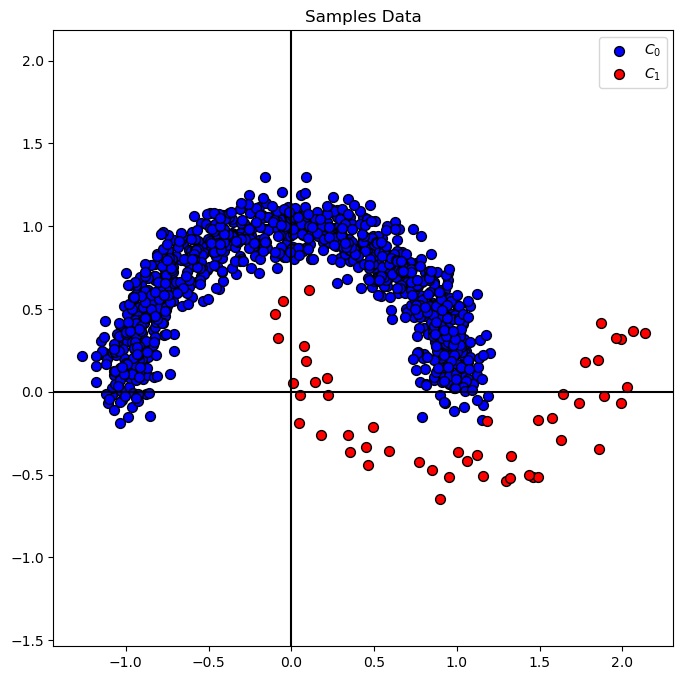

In [8]:
# Plot the Data

# Class Indices
vIdx0 = vY == 0
vIdx1 = vY == 1

# Data Samples by Class
mX0 = mX[vIdx0]
mX1 = mX[vIdx1]

hA = PlotBinaryClassData(mX, vY, axisTitle = 'Samples Data')

### Distribution of Labels

When dealing with classification, it is important to know the balance between the labels within the data set.

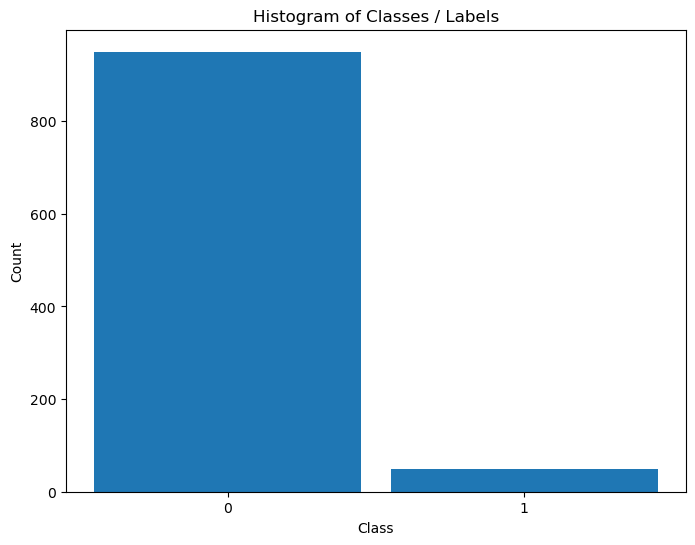

In [9]:
# Distribution of Labels

hA = PlotLabelsHistogram(vY)
plt.show()

## Train SVM Classifier

In [10]:
# SVM Linear Model

#===========================Fill This===========================#
# 1. Train a model and set the parameter `probability` to `True`
oSVM  = SVC(probability=True , C = paramC, kernel = kernelType).fit(mX, vY) #<! Trained model
#===============================================================#

modelScore = oSVM.score(mX, vY)

print(f'The model score (Accuracy) on the data: {modelScore:0.2%}') #<! Accuracy

The model score (Accuracy) on the data: 97.40%


### Plot Decision Boundary

We'll display, the linear, decision boundary of the classifier.

In [11]:
# Decision Boundary Plotter (Per Data!)
# Look at the implementation for an example for a Closure in Python.

PlotDecisionBoundary = PlotDecisionBoundaryClosure(numGridPts, mX[:, 0].min(), mX[:, 0].max(), mX[:, 1].min(), mX[:, 1].max())


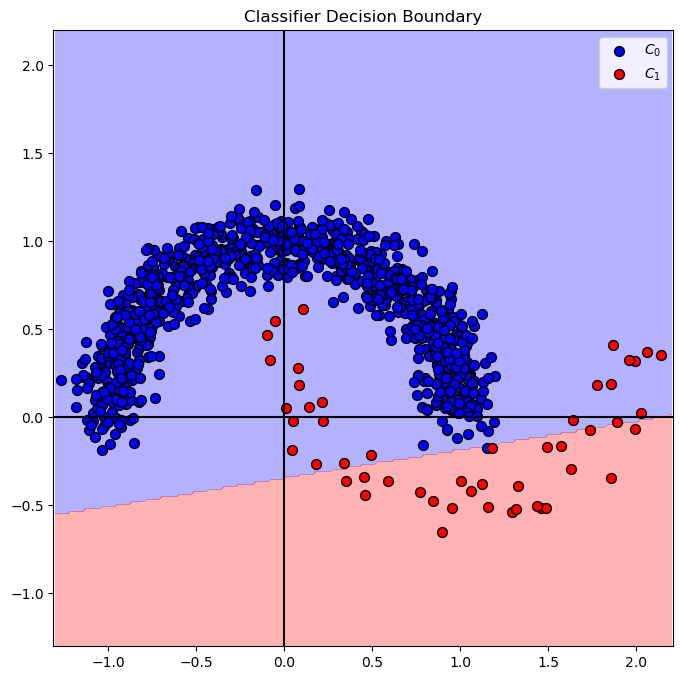

In [12]:
# Decision Boundary
# Plotting the decision boundary.
hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA = PlotDecisionBoundary(oSVM.predict, hA)
hA = PlotBinaryClassData(mX, vY, hA = hA, axisTitle = 'Classifier Decision Boundary')
plt.show()

In [13]:
# Prediction Confidence Level (Probability)

#===========================Fill This===========================#
# 1. Evaluate the decision function for `mX`.
# 2. Calculate the probability function for `mX`.
# !! You should use the `decision_function()` and `predict_proba()` methods.
vD = oSVM.decision_function(mX) #<! Apply the decision function of the data set
mP = oSVM.predict_proba(mX) #<! Probabilities per class
#===============================================================#

## print head of VD and MP
print(f'Head of the decision function: {vD[:5]}')
print(f'Head of the probability function: {mP[:5]}')


Head of the decision function: [-1.54704399 -3.38370013 -2.42502863 -0.85535956 -1.35494398]
Head of the probability function: [[0.93917258 0.06082742]
 [0.99855142 0.00144858]
 [0.98972631 0.01027369]
 [0.79726216 0.20273784]
 [0.9160934  0.0839066 ]]


In [14]:
isMatch = np.all(np.argmax(mP, axis = 1) == (vD > 0))
print(f'The decision boundary and probability score match: {isMatch}')


The decision boundary and probability score match: False


* <font color='red'>(**?**)</font> Describe the decision score of the points.
* <font color='red'>(**?**)</font> What are the units of `vD` and `mP`? Why do they have different shapes?

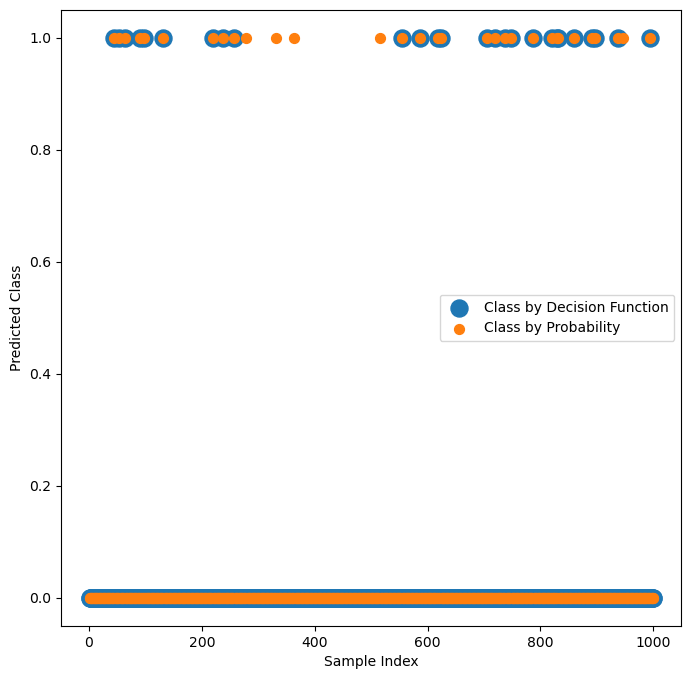

In [15]:
# Plot the Decision Function Output vs. the Probability
# The built in probability doesn't match the decision function of the classifier!

hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
vSampleIdx = list(range(1, mX.shape[0] + 1))

hA.scatter(vSampleIdx, vD > 0, s = 3 * ELM_SIZE_DEF, label = 'Class by Decision Function')
hA.scatter(vSampleIdx, np.argmax(mP, axis = 1), s = ELM_SIZE_DEF, label = 'Class by Probability')
hA.set_xlabel('Sample Index')
hA.set_ylabel('Predicted Class')
hA.legend()

plt.show()

* <font color='red'>(**?**)</font> Explain the graph. Make sure you understand the calculation.
* <font color='red'>(**?**)</font> Which one matches the trained model?

### Alternative Probability Function

The `SVC` class uses the [_Platt Scaling_](https://en.wikipedia.org/wiki/Platt_scaling) for estimating the probabilities.  
As such, it doesn't always match the results given by the _decision boundary_ (Though it is based on it).

In this section an alternative method is presented where:

$$ p \left( \hat{y}_{i} = 1 \mid {d}_{i} \right) = 0.5 \left( 1 + \operatorname{sign} \left( {d}_{i} \right) \left( 1 - {e}^{- \left| {d}_{i} \right|} \right) \right) $$

Where ${d}_{i} = \boldsymbol{w}^{T} \boldsymbol{x}_{i} - b$ is the "distance" of the point (With a sign) form the decision boundary.

* <font color='brown'>(**#**)</font> The motivation of this function is giving intuition and not being a calibration process of a function.

* <font color='red'>(**?**)</font> What is required for ${d}_{i}$ to be the actual distance?
* <font color='red'>(**?**)</font> In binary classification, what would be $p \left( \hat{y}_{i} = 0 \mid {d}_{i} \right)$? 
* <font color='red'>(**?**)</font> Are there any points which get probability of $1$? 

In [16]:
# Probability function for Binary SVM Classifier
# Idea is to create function which matches the decision function.

#===========================Fill This===========================#
# 1. Create the function `SvcBinProb` to assign a probability for the SVC Classifier.
# 2. The output is a matrix of shape `(numSamples, 2)`.
# 3. Per class calculate the probability as defined above.
# !! The input is the per sample output of `decision_function()` method.
def SvcBinProb( vD: np.ndarray ) -> np.ndarray:
    mP = np.zeros(shape = (vD.shape[0], 2)) #<! Pre allocate the output

    mP[:, 1] = 0.5 * (1 + np.sign(vD) * (1 - np.exp(-np.abs(vD)))) #<! The probability of the positive class
    mP[:, 0] = 1 - mP[:, 1] #<! The probability of the negative class

    return mP
#===============================================================#

In [17]:
# Probability per Sample per Class
# Calculate the probability matrix using `SvcBinProb`.

#===========================Fill This===========================#
# 1. Calculate the probability matrix.
# !! Each class is a column.
mP = SvcBinProb(vD)
#===============================================================#

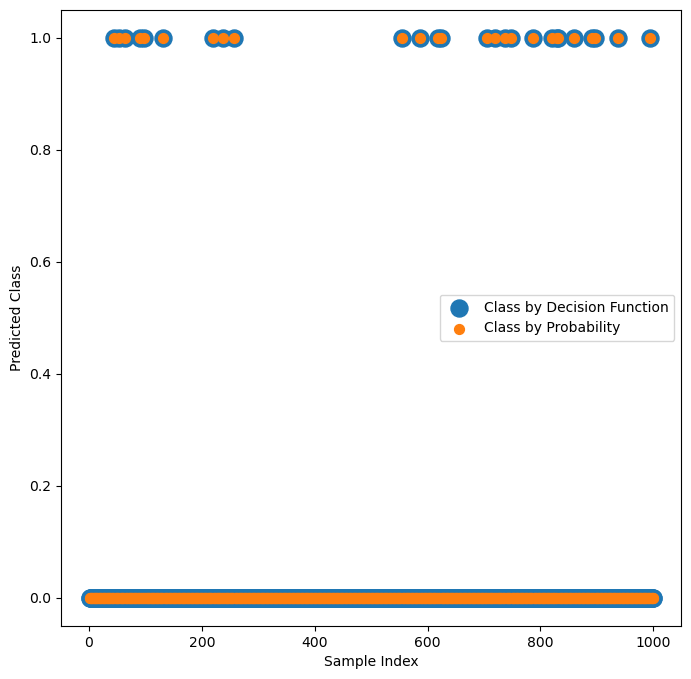

In [18]:
# Verify visually that the classification by `mP` and `vD` match

hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
vSampleIdx = list(range(1, mX.shape[0] + 1))

hA.scatter(vSampleIdx, vD > 0, s = 3 * ELM_SIZE_DEF, label = 'Class by Decision Function')
hA.scatter(vSampleIdx, np.argmax(mP, axis = 1), s = ELM_SIZE_DEF, label = 'Class by Probability')
hA.set_xlabel('Sample Index')
hA.set_ylabel('Predicted Class')
hA.legend()

plt.show()

In [19]:
# The Probability vs. Decision Function
# Check programmatically that the classification by `mP` and `vD` match.

#===========================Fill This===========================#
isMatch = np.all(np.argmax(mP, axis = 1) == (vD > 0))
#===============================================================#

print(f'The decision boundary and probability score match: {isMatch}')


The decision boundary and probability score match: True


## Tuning Metrics / Scores

In _real world_ the score is used to tune the hyper parameter of the training loop to maximize the real world performance.  
In this section we'll show the effect of the tuning on the performance and the decision boundary.

### Probability Threshold Tuning

Most classifiers have a threshold based decision rule for binary classification.  
In many cases it is based on probability on others (Such as in the SVM) on a different confidence function.  

In the above we transform the confidence function of the SVM into probability.  
Now, we'll use the probability threshold as a way to play with the _working point_ of the classifier.

In [20]:
# Metrics by Probability

#===========================Fill This===========================#
# 1. Extract the probability of the positive class.
# !! The array `mP` has the probability for both classes.
#    Extract from it the probability of Class = 1.

vP = mP[:, 1]
#===============================================================#

vFP, vTP, vThr = roc_curve(vY, vP, pos_label = 1)
aucVal         = auc(vFP, vTP)

In [21]:
# Plotting Function

hDecFunc = lambda XX, probThr: SvcBinProb(oSVM.decision_function(XX))[:, 1].reshape((numGridPts, numGridPts)) > probThr

def PlotRoc( probThr: float ):
    _, vAx = plt.subplots(1, 2, figsize = (14, 6))
    hA = vAx[0]
    hA.plot(vFP, vTP, color = 'b', lw = 3, label = f'AUC = {aucVal:.3f}')
    hA.plot([0, 1], [0, 1], color = 'k', lw = 2, linestyle = '--')

    vIdx = np.flatnonzero(vThr < probThr)
    if vIdx.size == 0:
        idx = -1
    else:
        idx = vIdx[0] - 1

    hA.axvline(x = vFP[idx], color = 'g', lw = 2, linestyle = '--')
    hA.set_xlabel('False Positive Rate')
    hA.set_ylabel('True Positive Rate')
    hA.set_title ('ROC')
    hA.axis('equal')
    hA.legend()
    hA.grid()    
    
    hA = vAx[1]

    hA = PlotDecisionBoundary(lambda XX: hDecFunc(XX, probThr), hA)
    hA = PlotBinaryClassData(mX, vY, hA = hA)
    


In [22]:
# Interactive Plot
probThrSlider = FloatSlider(min = 0.0, max = 1.0, step = 0.01, value = 0.5, readout_format = '0.2%', layout = Layout(width = '30%'))
interact(PlotRoc, probThr = probThrSlider)

plt.show()

interactive(children=(FloatSlider(value=0.5, description='probThr', layout=Layout(width='30%'), max=1.0, reado…

### Resampling

Another way to have a better default classifier for the imbalanced data is to resample the data in a balanced way:

![](https://i.imgur.com/kPGo65I.png)

* <font color='brown'>(**#**)</font> There is a dedicated Python package for that called [`imbalanced-learn`](https://github.com/scikit-learn-contrib/imbalanced-learn) which automates this.  
  It also uses some more advanced tricks. Hence in practice, if you chose resampling approach, use it.
* <font color='brown'>(**#**)</font> While in the following example we'll resample the whole data set, in practice we'll do resampling only on the training data set.  
  This is in order to avoid _data leakage_.

#### Undersampling

In case we have enough samples to learn from in the smaller class, this is the way to go.

In [23]:
np.random.choice(10, 4, replace = False)

array([8, 7, 6, 3])

In [24]:
# Under Sample the Class 0 Samples
# Using Numpy `choice()` we can resample indices with or without replacement.
# In this case we need to undersample, hence with no replacement.

#===========================Fill This===========================#
vIdx0UnderSample = np.random.choice(mX0.shape[0], mX1.shape[0], replace = False)
mX0UnderSample   = mX0[vIdx0UnderSample]
#===============================================================#

mXS = np.vstack((mX0UnderSample, mX1))
vYS = np.concatenate((np.zeros(mX0UnderSample.shape[0], dtype = vY.dtype), np.ones(mX1.shape[0], dtype = vY.dtype)))

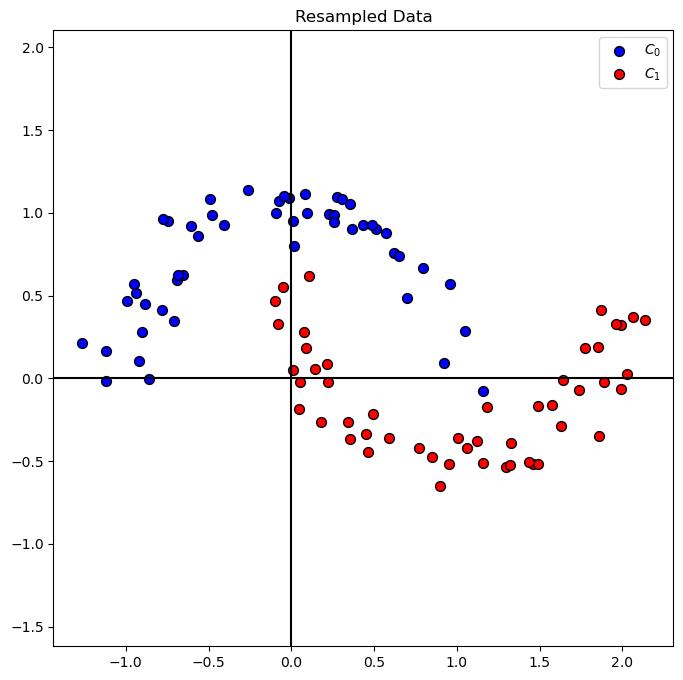

In [25]:
# Plot Resampled Data
hA = PlotBinaryClassData(mXS, vYS, axisTitle = 'Resampled Data')

In [26]:
# SVM Linear Model
oSVM  = SVC(C = paramC, kernel = kernelType).fit(mXS, vYS) #<! Fit on the new sampled data

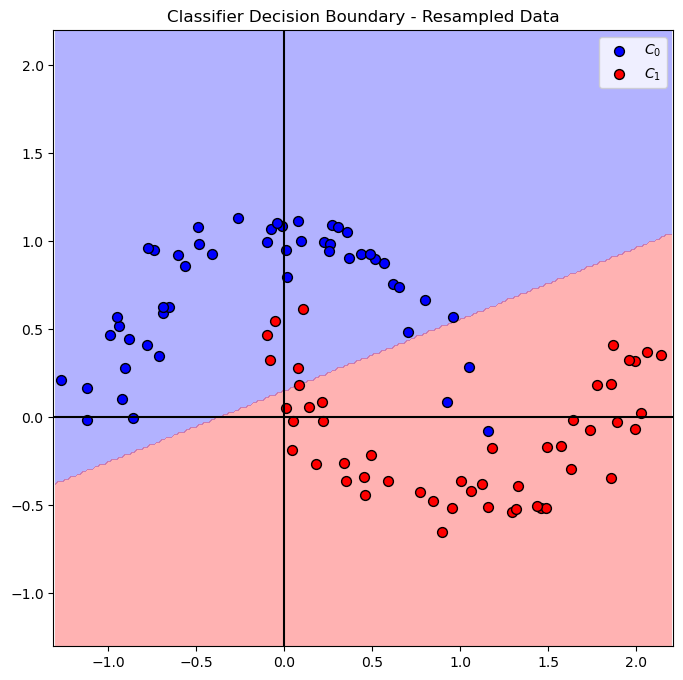

In [27]:
# Plot Decision Boundary
hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA = PlotDecisionBoundary(oSVM.predict, hA)
hA = PlotBinaryClassData(mXS, vYS, hA = hA, axisTitle = 'Classifier Decision Boundary - Resampled Data')
plt.show()

#### Oversampling

In this case we resample the less populated class to have similar number of samples as the more populated class.

In [28]:
np.size(vY) - np.sum(vY == 1)

950

In [29]:
# Over Sample the Class 1 Samples
# In this case we'll utilize `choice()` with replacement.

#===========================Fill This===========================#
# 1. Calculate the number of sample to generate.
# 2. Resample from the relevant class. 
# 3. Create the oversampled data.
# !! Make sure you use the `replace` option properly.
numSamplesGenerate = np.size(vY) - np.sum(vY == 1)
vIdx1OverSample = np.random.choice(mX1.shape[0], numSamplesGenerate, replace = True)
mX1OverSampleSample = mX1[vIdx1OverSample]

print(f' num of feat1 = {mX0.shape[0]}') 
print(f' num of feat2 = {mX1.shape[0]}') 
print(f' add to mX1 random [1:{mX1.shape[0]}] more case = {numSamplesGenerate} ')
print(f' mX1OverSampleSample size = {mX1OverSampleSample.shape[0]}')
#===============================================================#

mXS = np.vstack((mX0, mX1OverSampleSample))
vYS = np.concatenate((np.zeros(mX0.shape[0], dtype = vY.dtype), np.ones(mX1OverSampleSample.shape[0], dtype = vY.dtype)))


 num of feat1 = 950
 num of feat2 = 50
 add to mX1 random [1:50] more case = 950 
 mX1OverSampleSample size = 950


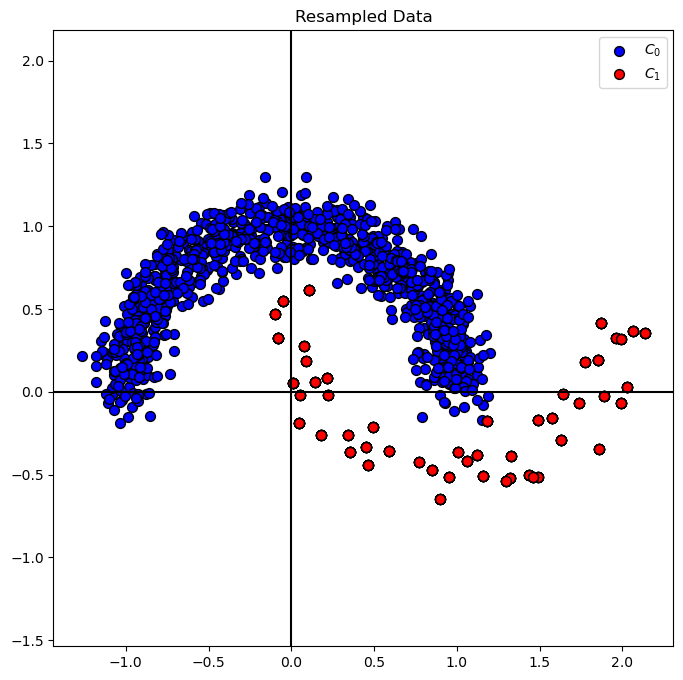

In [30]:
# Plot Resampled Data
hA = PlotBinaryClassData(mXS, vYS, axisTitle = 'Resampled Data')
plt.show()

In [31]:
# SVM Linear Model
oSVM  = SVC(C = paramC, kernel = kernelType).fit(mXS, vYS) #<! Fit on the new sampled data

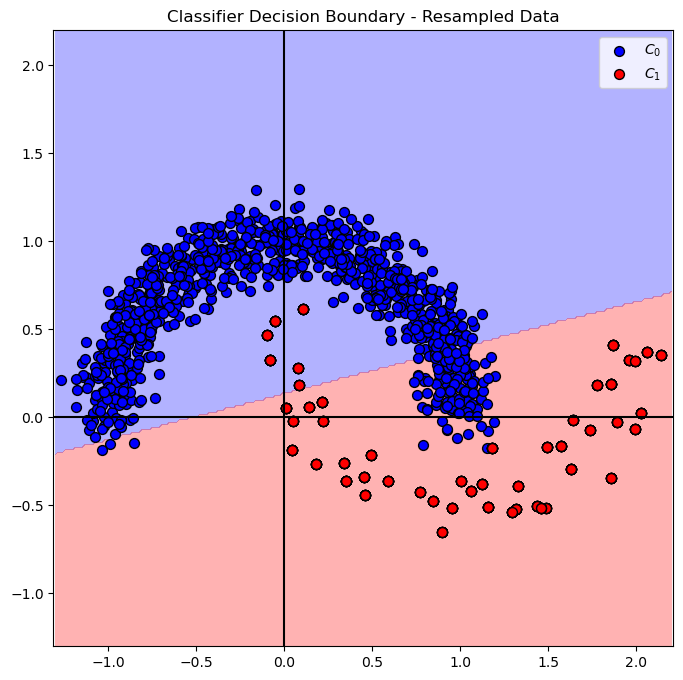

In [32]:
# Plot Decision Boundary
hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA = PlotDecisionBoundary(oSVM.predict, hA)
hA = PlotBinaryClassData(mXS, vYS, hA = hA, axisTitle = 'Classifier Decision Boundary - Resampled Data')
plt.show()

* <font color='red'>(**?**)</font> Is the result the same as in the _under sample_ method? Why?

### Data Weighing

Another approach is changing the weights of the data.  
We have 2 methods here:

 - Weight per Sample  
   This is very similar in effect to resample the sample. The difference is having ability for non integer weight.  
   It may not be available in all classifiers on SciKit Learn (For example, `SVC` doesn't support this).
 - Weight per Class  
   Applies the weighing on the samples according to their class.   
   Usually applied in SciKit Learn under `class_weight`.
   It has a `balanced` option which tries to balance imbalanced data.

In [33]:
# SVM Linear Model - Balanced Weighing

#===========================Fill This===========================#
oSVM  = SVC(C = paramC, kernel = kernelType, class_weight = 'balanced').fit(mX, vY)
#===============================================================#

* <font color='red'>(**?**)</font> Explain the difference between the _class weight_ as part of the model and the `sample weight_ as part of the fitting process.
* <font color='red'>(**?**)</font> Can we achieve the same as above using the class weight?

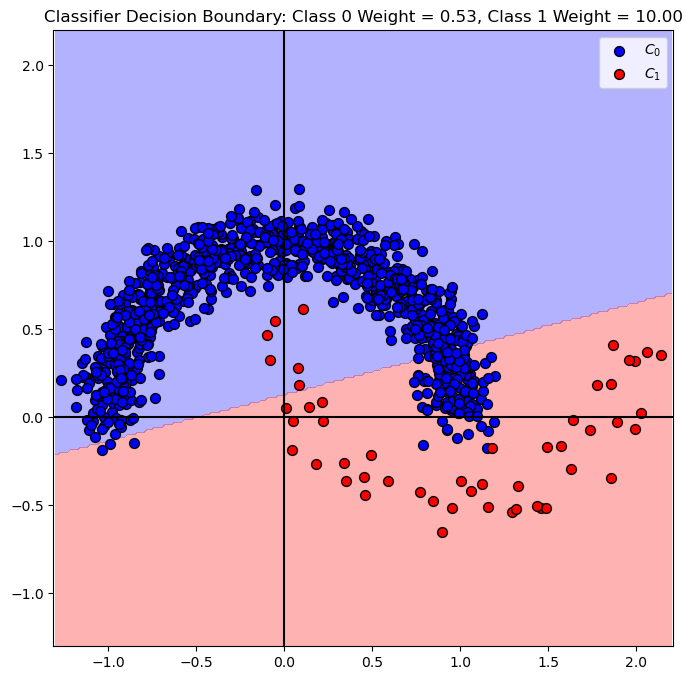

In [34]:
# Plot Decision Boundary
hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA = PlotDecisionBoundary(oSVM.predict, hA)
hA = PlotBinaryClassData(mX, vY, hA = hA, axisTitle = f'Classifier Decision Boundary: Class 0 Weight = {oSVM.class_weight_[0]:0.2f}, Class 1 Weight = {oSVM.class_weight_[1]:0.2f}')
plt.show()

In [35]:
# SVM Linear Model - Manual Weighing
# We'll set the weight of the class 0 to 1, and class 1 to 1000.

#===========================Fill This===========================#
dClassWeight = {0: 1, 1: 1000} #<! Weighing dictionary
#===========================Fill This===========================#

oSVM  = SVC(C = paramC, kernel = kernelType, class_weight = dClassWeight).fit(mX, vY)

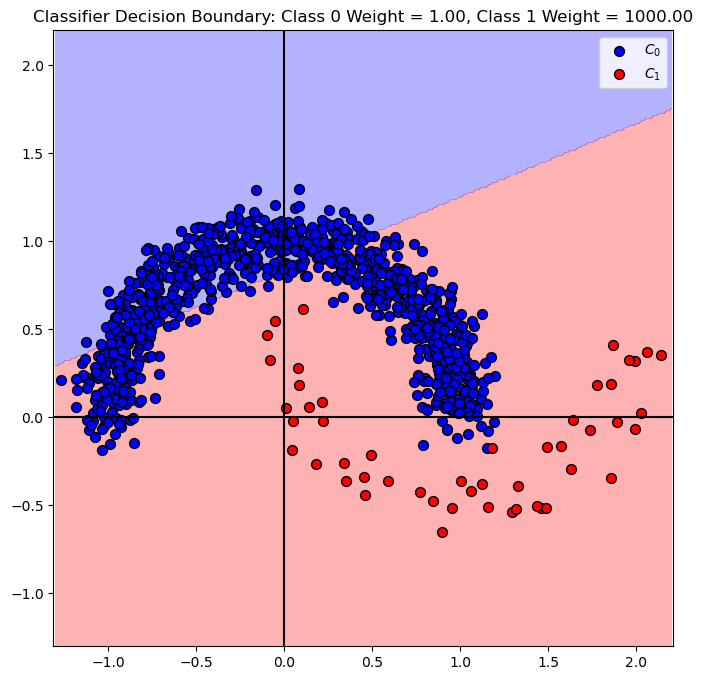

In [36]:
# Plot Decision Boundary
hF, hA = plt.subplots(figsize = FIG_SIZE_DEF)
hA = PlotDecisionBoundary(oSVM.predict, hA)
hA = PlotBinaryClassData(mX, vY, hA = hA, axisTitle = f'Classifier Decision Boundary: Class 0 Weight = {oSVM.class_weight_[0]:0.2f}, Class 1 Weight = {oSVM.class_weight_[1]:0.2f}')
plt.show()